# Réduction des dimensions

On peut souhaiter réduire de nombre de dimensions d'un jeu de données :

- pour le compresser : diminution le volume d'informations utiles à stocker et par la même occasion la durée d'exécution d'un algorithme d'apprentisssage (car l'espace à explorer est plus petit)
- pour n'en conserver que les caractéristiques (features) discriminantes et éviter ainsi le surapprentissage (apprentissage du bruit dans les données)

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt # traçage de graphiques
import numpy as np # traitement des arrays numériques
import pandas as pd

from sklearn import datasets # datasets classiques
from sklearn import preprocessing # normalisation les données
from sklearn import decomposition # PCA et NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

np.random.seed = 2017 # pour des résultats reproductibles

# 1. PCA - L'analyse en composante principale

## 1.1 Algorithme
**L'analyse en composante principale pour des données numériques en n dimensions est un algorithme non supervisé d'identification des dimensions de variance décroissante et de changement de base pour ne conserver que les k dimensions de plus grande variance.**

Il consiste à :

0. *Optionnel : Normaliser les données (important si les données n'ont par exemple pas été mesurées aux mêmes échelles)*
0. Construire la matrice de covariance entre les variables :
$\Sigma = \frac{1}{n-1}\sum_{i=1}^{n}{((X - \bar{x})'(X - \bar{x}))}$
0. Trouver les valeurs propres $\lambda_i$ et vecteurs propres $v_i$ :
$\Sigma v_i = \lambda_iv_i$, ces vecteurs propres forment un repère orthogonal de l'espace des données (en tant que vecteurs propres d'une matrice symmétrique qu'on supposera de rang n)
0. Classer les valeurs propres (et les vecteurs associés) de façon décroissante : $\{\lambda_{(n)}, \lambda_{(n-1)}...\lambda_{(1)} \}$ où $\lambda_{(i)}$ est la i-ème variance dans l'ordre croissant
0. Ne conserver que les k  ($k \leqslant n$)  premiers vecteurs : $\{v_{(n)}, v_{(n-1)}...v_{(n-k+1)} \}$
0. Construire la matrice de projection dans l'espace de ces vecteurs (changement de base si n=k)
0. Projeter les données initiales dans cet espace de dimension k
![Illustration PCA](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png)

Tout cela peut bien sur être implémenté from scratch avec Numpy mais nous utiliserons ici scikit-learn pour raccourcir l'implémentation et nous concentrer sur la visualisation des résultats.
Cf. https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales et http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

## 1.2 Implémentation avec scikit-learn
### 1.2.1 Données
Nous partirons classiquement du dataset Iris (classification de 3 fleurs sur la base de certaines de leurs mesures) :

In [3]:
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

Dimensions de l'espace de départ : 4
Représentation des données dans ces dimensions :


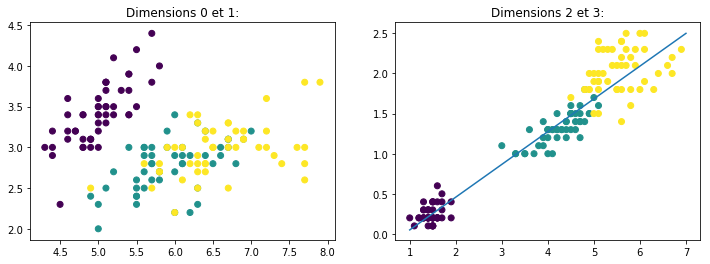

In [4]:
print("Dimensions de l'espace de départ : {}".format(X_iris.shape[1]))
print("Représentation des données dans ces dimensions :")

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title("Dimensions 0 et 1:")
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris)
plt.subplot(1, 2, 2)
plt.title("Dimensions 2 et 3:")
plt.scatter(X_iris[:, 2], X_iris[:, 3], c=y_iris)
plt.plot([1,7],[0.05,2.5])
plt.show()

### 1.2.2 Premier exemple de PCA
Graphiquement, on peut se dire que les 2 dernières dimensions sont très corrélées et donc redondantes. Dans un strict but de classification, on pourrait d'ailleurs presque se contenter de la dimension indiquée par la ligne bleue pour correctement discriminer les 3 types de fleurs (*nous verrons par la suite qu'il s'agit d'un cas particulier non généralisable*).

Effectuons une PCA avec scikit-learn avec un changemment de base conservant les 4 dimensions pour illustrer leurs différences :

In [5]:
# Gardons toutes les composantes pour le moment
# Nous pourrons toujours en retirer ensuite puisqu'elles seront triées par significativité
pca = decomposition.PCA(n_components=4)

X_iris_PCA = pca.fit(X_iris).transform(X_iris) 

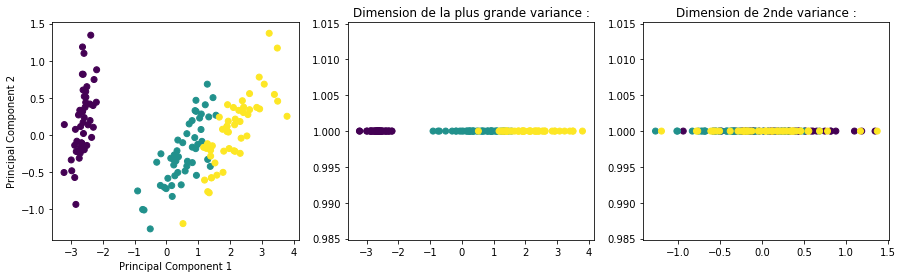

In [6]:
def graph_acp2(X_PC2, y):
    plt.figure(figsize=(15,4))
    plt.subplot(1, 3, 1)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X_PC2[:, 0], X_PC2[:, 1], c=y)
    plt.subplot(1, 3, 2)
    plt.title("Dimension de la plus grande variance :")
    plt.scatter(X_PC2[:, 0], np.ones(X_PC2.shape[0]), c=y)
    plt.subplot(1, 3, 3)
    plt.title("Dimension de 2nde variance :")
    plt.scatter(X_PC2[:, 1], np.ones(X_PC2.shape[0]), c=y)
    plt.show()

graph_acp2(X_iris_PCA, y_iris)

## 1.3 Quelques réserves
Comme évoqué dans la présentation, il est à noter qu'il s'agit d'un **algorithme non supervisé**, qui ne tient donc pas compte des étiquettes des données.
Dans le cas ci-dessus, nous avons eu la chance que les données soient linéairement séparables sur la dimension de plus grande variance. Dans le cas contraire, l'ACP aurait pu ne pas nous aider et nous aurions même pu perdre les dimensions selon lesquelles discriminer les données correctement.

A noter également que dans le cas de données de variance assez homogène selon toutes les dimensions, une ACP ne nous apporte rien.

**L'ACP peut donc être inutile voire contreproductive dans un objectif de classification.**

Ci-après 2 contre-exemples :

### 1.3.1 ACP et discrimination selon dimension de moindre variance

In [7]:
X11 = np.random.rand(30)*10
X21 = X11 + 1
X12 = np.random.rand(20)*10
X22 = X12 + 2
X = np.array([np.concatenate((X11,X12)),
              np.concatenate((X21,X22))]).T
y = np.concatenate((np.zeros(30), np.ones(20)))
X = preprocessing.scale(X, with_mean=True, with_std=True)

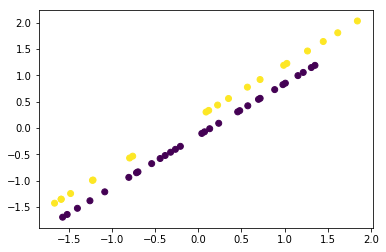

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

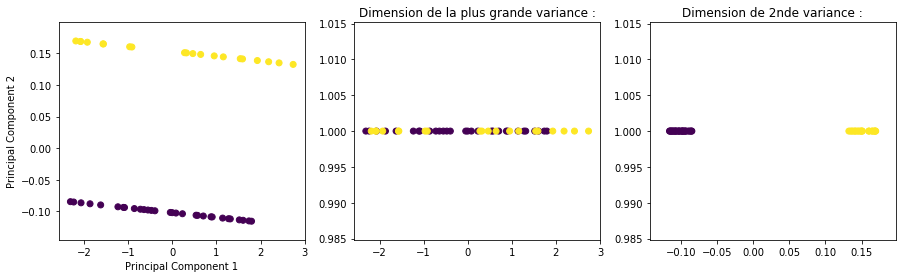

In [9]:
pca = decomposition.PCA(n_components=2)
X_PC2 = pca.fit(X).transform(X)
graph_acp2(X_PC2, y)

Ici une ACP ne retenant que la dimension de plus grande variance nous aurait donc fait perdre toute possibilité de discrimination.

### 1.3.2 ACP sur des données de variance homogène

In [10]:
X11 = np.random.normal(0, 10, 500)
X21 = abs(np.random.normal(0, 10, 500))
X12 = np.random.normal(0, 10, 500)
X22 = -abs(np.random.normal(0, 10, 500))
X = np.array([np.concatenate((X11,X12)),
              np.concatenate((X21,X22))]).T
y = np.concatenate((np.zeros(500), np.ones(500)))
y = y.astype(int)

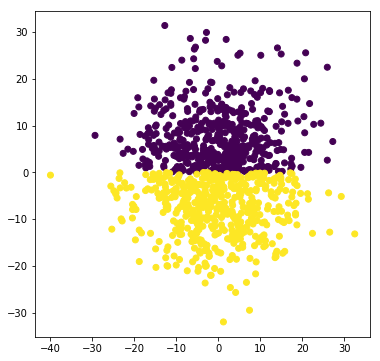

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [12]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_PC2 = pca.transform(X)

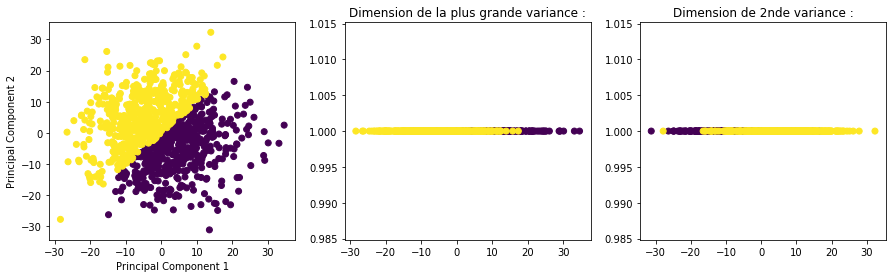

In [13]:
graph_acp2(X_PC2, y)    

Ici une ACP est inutile car la variance des données est homogène selon les dimensions initiales (cf. orientation diagonale entre les 2 classes).

# 2. Autres méthodes
D'autres méthodes, que nous détaillerons moins pour le moment, peuvent être plus pertinentes que l'ACP dans certains contextes :

## 2.1 L'[analyse discriminante linéaire ou quadratique](http://scikit-learn.org/stable/modules/lda_qda.html) (LDA/QDA)
Plutôt que de maximiser la variance sur des dimensions des données, on va ici chercher à maximiser la variance inter-classes par rapport à celle intra classe. Cette méthode transformera donc l'espace d'origine en un espace plus adapté que l'ACP dans un objectif de classification.

Rappel des composantes identifiées par le PCA :


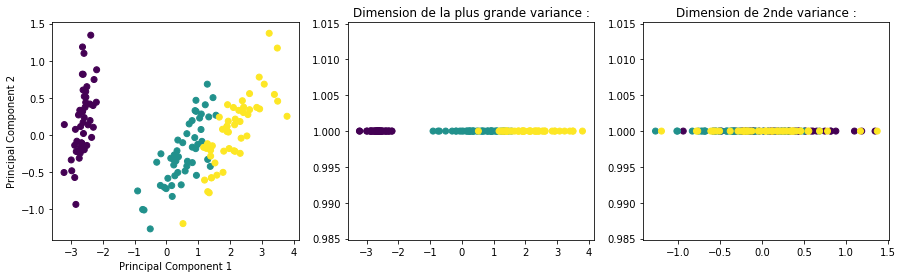

Composantes identifiées par le LDA (on remarque une meilleure séparation des classes sur la 1ère composante) :


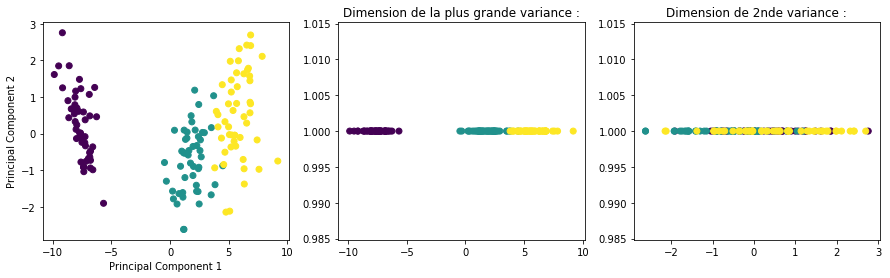

In [14]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_iris_LDA = lda.fit(X_iris, y_iris).transform(X_iris)

print("Rappel des composantes identifiées par le PCA :")
graph_acp2(X_iris_PCA, y_iris) 
print("Composantes identifiées par le LDA (on remarque une meilleure séparation des classes sur la 1ère composante) :")
graph_acp2(X_iris_LDA, y_iris) 

# 2.1La [factorisation de matrices](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
On va ici chercher à approcher une matrice **V de dimensions m\*n**, de grande taille souvent creuse et positive (e.g. les évaluations de tous les clients sur tous les produits dans un site marchand), par un **produit d'une matrice W de dimensions m\*k** (e.g. le profils de tous les clients) **avec une matrice H de dimensions k\*n** (e.g. les évaluations moyennes pour ces profils). Nous chercherons ainsi à avoir (m\*k + k\*n) << m\*n pour diminuer l'espace de représentation de nos données, tout en conservant le maximum d'information.

$$
\begin{bmatrix}
    v_{11}       & v_{12} & v_{13} & \dots  & v_{1n} \\
    v_{21}       & v_{22} & v_{23} & \dots  & v_{2n} \\
    v_{31}       & V_{32} & v_{33} & \dots  & v_{3n} \\
    \vdots       & \vdots & \vdots & \ddots & \vdots \\
    v_{m1}       & V_{m2} & v_{m3} & \dots  & v_{mn}
\end{bmatrix}
=
\begin{bmatrix}
    w_{11} & \dots  & w_{1k} \\
    w_{21} & \dots  & w_{2k} \\
    w_{31} & \dots  & w_{3k} \\
    \vdots & \ddots & \vdots \\
    w_{m1} & \dots  & w_{mk}
\end{bmatrix}
*
\begin{bmatrix}
    h_{11} & h_{12} & h_{13} & \dots  & h_{1n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    h_{k1} & h_{k2} & h_{k3} & \dots  & h_{kn}
\end{bmatrix}
$$

Sans entrer dans les détails, ces algorithmes consisteront à trouver W et H qui minimisent $||V - W*H ||_F^2$. Il est  à noter que la solution minimisant cette norme peut ne pas être unique. De plus ces algorithmes sont multiples, souvent de complexité computationnelle élevée et requièrent des régularisations.

A titre d'exemple construisons une matrice de notations de films par des utilisateurs que nous allons tâcher de factoriser en une matrice de profils (les goûts de chaque utilisateurs) et une autre de catégories de films (les profils auxquels ces films sont susceptibles de plaire). Ces notations vont de 1 à 9 et on désignera par 0 l'absence de note. Cet exemple est volontairement simpliste et ne peut pas passer à l'échelle ni être généralisé trivialement.

In [15]:
df = pd.DataFrame.from_dict({'loves_everything': [9,9,9,9,9,9,0],
                             'big_guns':         [1,2,1,8,9,8,9],
                             'testosterone guy': [0,0,1,9,9,9,7],
                             'girlygirl':        [9,0,8,1,0,0,7],
                             'romance_addict':   [9,8,0,0,0,1,0],
                             'machoman':         [0,1,0,8,7,9,8],
                             'loves_flowers':    [7,8,0,0,0,0,8],
                             'easily_pleased':   [0,8,8,0,7,9,7],
                             'chuck_norris_fan': [0,2,0,9,0,9,8],
                             'mylittleponey98':  [7,0,7,0,1,0,8],
                             'allmoviesrock':    [7,8,0,0,7,8,7],
                             'more_guns_please': [0,2,0,9,8,0,7],
                             'yeah_guns666':     [1,0,3,0,9,9,0]},
                           ).transpose()
df.index.name = "Users"
df.columns = ['Charming prince', 'First date', 'Lovely love', 'Guns are cool', 'Ultra badass 4', 'My fist in your face', 'Guns & roses']
df.columns.name = "Movies"
df

Movies,Charming prince,First date,Lovely love,Guns are cool,Ultra badass 4,My fist in your face,Guns & roses
Users,,,,,,,
allmoviesrock,7,8,0,0,7,8,7
big_guns,1,2,1,8,9,8,9
chuck_norris_fan,0,2,0,9,0,9,8
easily_pleased,0,8,8,0,7,9,7
girlygirl,9,0,8,1,0,0,7
loves_everything,9,9,9,9,9,9,0
loves_flowers,7,8,0,0,0,0,8
machoman,0,1,0,8,7,9,8
more_guns_please,0,2,0,9,8,0,7


In [16]:
nmf = decomposition.NMF(n_components=2,
                        random_state=1,
                        alpha=.1,
                        l1_ratio=.5).fit(df)

In [17]:
profiles = pd.DataFrame(nmf.transform(df),
                        index=df.index,
                        columns=['action lover', 'romcom lover'])
profiles.columns.name = 'Categories'
profiles

Categories,action lover,romcom lover
Users,,
allmoviesrock,1.364464,1.788403
big_guns,2.542310,0.229329
chuck_norris_fan,1.945916,0.072006
easily_pleased,1.649300,1.397724
girlygirl,0.031053,2.159935
loves_everything,1.847780,2.263489
loves_flowers,0.092489,2.079689
machoman,2.436259,0.000000
more_guns_please,1.755344,0.047097


In [18]:
profiles = profiles > 1
profiles

Categories,action lover,romcom lover
Users,,
allmoviesrock,True,True
big_guns,True,False
chuck_norris_fan,True,False
easily_pleased,True,True
girlygirl,False,True
loves_everything,True,True
loves_flowers,False,True
machoman,True,False
more_guns_please,True,False


In [19]:
movie_cat = pd.DataFrame(nmf.components_,
                         columns=df.columns,
                         index=['action lover', 'romcom lover'])
movie_cat.index.name = 'Categories'
movie_cat = movie_cat > 1

In [20]:
movie_cat

Movies,Charming prince,First date,Lovely love,Guns are cool,Ultra badass 4,My fist in your face,Guns & roses
Categories,,,,,,,
action lover,False,False,False,True,True,True,True
romcom lover,True,True,True,False,False,False,True


Nous avons donc bien obtenu une matrice de profils et une autre de catégories de films dont la multiplication nous donnera approximativement les goûts des utilisateurs pour chaque film, y compris ceux qu'ils n'ont pas vus ou évalués.